In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
import PIL as PIL
import time

from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from scipy.ndimage import sobel
from PIL import Image
from skimage import io 
from skimage.io import imread, imshow
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(threshold = 1000000)

In [2]:
image = np.load(r"image_train00.npy")

Implement a class RigidTransform, which should specify a 3D rigid transformation which can warp 3D image volumes.

Implement a class member function compute_ddf, which takes a three-item tuple, representing the warped image size, and returns a NumPy array that defines a 3D displacement vector (from warped image to original image) at each (warped image) voxel locations. This dense displacement field (DDF) should also be precomputed in __init__ and stored in the returned class object.

In [3]:
def compose(theta_z1, theta_y1, theta_x1, T_z1, T_y1, T_x1):
    
#Transformation 1
    Translation1 = np.array([[1, 0, 0, T_z1],
                            [0, 1, 0, T_y1],
                            [0, 0, 1, T_x1],
                            [0, 0, 0, 1]])

    Rot_Z1 = np.array([[1, 0, 0, 0],
                    [0, np.cos(theta_z1), -np.sin(theta_z1), 0],
                    [0, np.sin(theta_z1), np.cos(theta_z1), 0],
                    [0, 0, 0, 1]])

# Rotation around the y-axis
    Rot_Y1 = np.array([[np.cos(theta_y1), 0, np.sin(theta_y1), 0],
                    [0, 1 , 0, 0],
                    [-np.sin(theta_y1), 0, np.cos(theta_y1), 0],
                    [0, 0, 0, 1]])

# Rotation around the x-axis
    Rot_X1 = np.array([[np.cos(theta_x1), -np.sin(theta_x1), 0, 0],
                    [np.sin(theta_x1), np.cos(theta_x1) , 0, 0],
                    [0, 0 , 1, 0],
                    [0, 0, 0, 1]])
    
    

    T_1 = Rot_Z1 @ Rot_Y1 @ Rot_X1 @ Translation1

    return T_1
    #T_2 = Rot_Z2 @ Rot_Y2 @ Rot_X2 @ Translation_2
    #T_3 = T_1 @ 

In [8]:
class RigidTransform:
    def __init__(self, image, theta_z, theta_y, theta_x, T_z, T_y, T_x, voxel_size_zyx):
        self.image = image
        self.voxel_size_z = voxel_size_zyx[0]
        self.voxel_size_y = voxel_size_zyx[1]
        self.voxel_size_x = voxel_size_zyx[2]

        # Physical size of image in each dimension (mm) 
        self.length_z = (self.image.shape[0])*(self.voxel_size_z)
        self.length_y = (self.image.shape[1])*(self.voxel_size_y)
        self.length_x = (self.image.shape[2])*(self.voxel_size_x)

# Create grid for original data
        self.z_grid = np.arange(0, self.length_z, self.voxel_size_z)
        self.y_grid = np.arange(0, self.length_y, self.voxel_size_y)
        self.x_grid = np.arange(0, self.length_x, self.voxel_size_x)

# Create a regular meshgrid with coordinates at which the intensity values will be interpolated 
        self.Z, self.Y, self.X = np.meshgrid([self.z_grid], [self.y_grid], [self.x_grid], indexing = "ij")
        self.coordinate_grid = np.array([self.Z, self.Y, self.X])
        self.support_points = ([self.z_grid, self.y_grid, self.x_grid])
        
        self.transformation = self.compute_transform(theta_z, theta_y, theta_x, T_z, T_y, T_x)
        self.ddf = self.compute_ddf(self.transformation)
        self.warped_image = self.warp(self.ddf)
        #self.composed_ddf = self.compute_ddf(self, composed_transform)
    
        
    def compute_ddf(self, transformation):

# Add a 1 to each coordinate to convert to homogeneous coordinates
        total_pixels = self.image.shape[0]*self.image.shape[1]*self.image.shape[2]
        ones = np.reshape(np.ones(total_pixels), (self.image.shape[0], self.image.shape[1], self.image.shape[2]))
        coords = np.array([self.Z.flatten(), self.Y.flatten(), self.X.flatten(), ones.flatten()])

# Perform transformation
        transform = transformation @ coords

# Reshape the transformed coordinates into a displacement field with the same shape as the original image
        ddf_ones = np.reshape(transform, coords.shape)

#Remove homogeneous coordinates
        ddf_flat = np.delete(ddf_ones,3,0)

# Reshape to size of original coordinate grid
        ddf = np.reshape(ddf_flat, self.coordinate_grid.shape)
        return ddf

    def warp(self, ddf):
        warp_grid = np.transpose(self.ddf)
        interpolated_image = []
        for point in warp_grid:
            int = sp.interpolate.interpn(self.support_points, self.image, point , method = "linear", bounds_error = False, fill_value = 0)
            interpolated_image.append(int)
        return np.transpose(interpolated_image)

    def compute_transform(self, theta_z, theta_y, theta_x, T_z, T_y, T_x):
        #Transformation 1
        translation = np.array([[1, 0, 0, T_z],
                            [0, 1, 0, T_y],
                            [0, 0, 1, T_x],
                            [0, 0, 0, 1]])

        Rot_Z = np.array([[1, 0, 0, 0],
                    [0, np.cos(theta_z), -np.sin(theta_z), 0],
                    [0, np.sin(theta_z), np.cos(theta_z), 0],
                    [0, 0, 0, 1]])

# Rotation around the y-axis
        Rot_Y = np.array([[np.cos(theta_y), 0, np.sin(theta_y), 0],
                    [0, 1 , 0, 0],
                    [-np.sin(theta_y), 0, np.cos(theta_y), 0],
                    [0, 0, 0, 1]])

# Rotation around the x-axis
        Rot_X = np.array([[np.cos(theta_x), -np.sin(theta_x), 0, 0],
                    [np.sin(theta_x), np.cos(theta_x) , 0, 0],
                    [0, 0 , 1, 0],
                    [0, 0, 0, 1]])
        
        transformation = Rot_Z @ Rot_Y @ Rot_X @ translation
        return transformation

    def compose(self, transformation_1, transformation_2):
        composed_transform = transformation_1 @ transformation_2
        return(composed_transform)

In [10]:
warp_1 = RigidTransform(image, 0, np.pi/30, 0, 0, 7,3, [2, 0.5,0.5])
warp_2 = RigidTransform(image, np.pi/60, np.pi/40, np.pi/12, 4, 6,6, [2, 0.5,0.5])
warp_3 = RigidTransform(image, np.pi/20, np.pi/12, np.pi/12, 5, 3,4, [2, 0.5,0.5])


#T_2 = np.array([[1, 0, 0, T_z1],
               # [0, 1, 0, T_y1],
               # [0, 0, 1, T_x1],
               # [0, 0, 0, 1]])

#print(warp_1.transformation @ warp_2.transformation)


#def compose(transformation_1, transformation_2):
   # composed_transform = transformation_1 @ transformation_2
    #print(composed_transform)

#compose_1 = compose(warp_1.transformation, warp_2.transformation)
#test23 = plt.imshow(compose_1.composed_warp_image[30, :, :], cmap="gray")


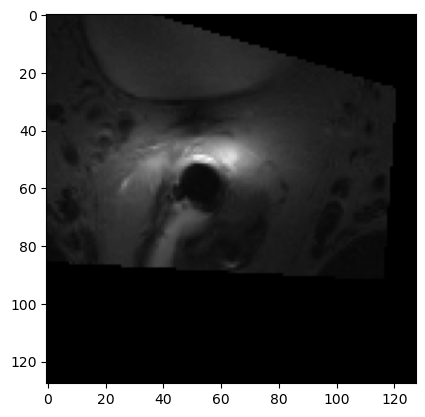

In [15]:
plt.imshow(warp_2.warped_image[30,:,:], cmap = "gray")